In [539]:
#compare to a base model
import pandas as pd
import numpy as np

In [540]:
#data
dataset = pd.read_csv('/home/kate/data/ClaimPrediction/fdata_v1_encd.csv', index_col=None)
target_column = 'hasclaim'

In [541]:
#models and analyzing results directory
ModelsDir='/home/kate/data/ClaimPrediction/k6_optparams/'

In [542]:
#comparing model metrics with t-test
#and save results
import scipy.stats as stats
def AnalyzeAndSaveModelsResults(result_df,result_lst,ModelName,filename):
    df=pd.DataFrame([result_lst])
    TestSizeColumns=['S0.45','S0.4','S0.35','S0.3','S0.25','S0.2','S0.15','S0.1']
    #TestSizeColumns=['S0.2','S0.15','S0.1']
    df.columns=['Model']+TestSizeColumns
    #mean
    df['Mean'] = df.drop('Model', axis=1).mean(axis=1)
    df['t-pvalue'] = 1
    df['t-statistic'] = 0
    df['Group'] = 1
    #t-test with base model
    if ModelName!='BaseModel':
        base_model=result_df[result_df['Model'] == 'BaseModel'].iloc[0]
        current_model=df.iloc[0]
        t=stats.ttest_ind(base_model[TestSizeColumns].tolist(),current_model[TestSizeColumns].tolist())
        line_to_save=[current_model['Model']]
        line_to_save.extend(current_model[TestSizeColumns].tolist())
        line_to_save.append(current_model[TestSizeColumns].mean())
        line_to_save.append(t.pvalue)
        line_to_save.append(t.statistic)
        if ((t.pvalue<=0.05) and (base_model['Mean']<current_model['Mean'])):
            line_to_save.append(2)
        elif ((t.pvalue<=0.05) and (base_model['Mean']>current_model['Mean'])):
            line_to_save.append(3)    
        else:
            line_to_save.append(1)                  
        df_to_save=pd.DataFrame([line_to_save])
        df_to_save.columns=['Model']+TestSizeColumns+['Mean','t-pvalue','t-statistic','Group']
        result_df=result_df.append(df_to_save, ignore_index=True)
    else:
        result_df=result_df.append(df, ignore_index=True)
    result_df.to_csv(ModelsDir+filename, index = False)
    return result_df

In [543]:
#xgb library and parameters to tune later
import xgboost as xgb
#Working
#xgb_params = {
#'colsample_bytree': 0.5,
#'eta': 0.02,
#'max_depth': 5,
#'subsample': 1,
#'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True,'booster': 'gbtree', 'seed': 42}   
#Adjusted Optimized
#xgb_params = {
# 'booster': 'gbtree',
# 'cosample_bytree': 0.9786846475506199,
# 'max_depth': 4,
# 'subsample': 0.76097593937313557,
# 'colsample_bylevel': 0.23209450560452577,
# 'eta': 0.012080410469107298,
# 'eval_metric': 'auc',
# 'silent': True,
# 'objective': 'binary:logistic',
# 'seed': 42}
#Original Working
xgb_params = {'eta': 0.02,
'max_depth': 4,
'subsample': 0.9,
'colsample_bytree': 0.9, 
'eval_metric': 'auc',
'silent': True,
'objective': 'binary:logistic',
'seed': 42}

In [544]:
#Evaluation metric to be used in tuning
from sklearn.metrics import roc_auc_score
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [545]:
#Random Undersampler to balance the dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
#ratio=0.918 to tune later

In [546]:
#StratifiedKFold
from sklearn.model_selection import StratifiedKFold
nrounds=5000 # need to change to 2000
kfold = 10  # need to change to 10
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [547]:
#splitting to train/test in the loop below
from sklearn.model_selection import train_test_split

In [548]:
#each line in the file contains the model name and set of features to analize
models = pd.read_csv(ModelsDir+'Models.csv', index_col=None)

In [549]:
#summary for test and train metrics for each model to test overfitting
models_test_gini_df=pd.DataFrame()
models_test_roc_auc_df=pd.DataFrame()
#
models_train_gini_df=pd.DataFrame()
models_train_roc_auc_df=pd.DataFrame()
#
base_model_df=pd.DataFrame()

In [550]:
for index, row in models.iterrows():
    #for test and train metrics for each model to test overfitting
    gini_test_lst=[]
    roc_auc_test_lst=[]
    gini_train_lst=[]
    roc_auc_train_lst=[]
    #Starting analyzing metric
    print (index, ': Analyzing model %s'%row['Model'])
    gini_test_lst.append(row['Model'])
    roc_auc_test_lst.append(row['Model'])
    gini_train_lst.append(row['Model'])
    roc_auc_train_lst.append(row['Model'])
    featureset=row[1:51].tolist()
    featureset=[x for x in featureset if str(x) != 'nan']
    #calculating metrics for the current featureset and 
    #several data sizes
    for s in (0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1):
    #for s in (0.2,0.15,0.1):
        print ('Test size %s'%s)
        X, X_test, y, y_test = train_test_split(dataset.loc[:,featureset], dataset[target_column], test_size=s, random_state=42)
        print('--------------------------------------------------------------------')
        print(row['Model'])
        print(len(X.columns))
        print(X.columns)
        print('--------------------------------------------------------------------')
        #prediction dataframes
        y_pred_test=pd.DataFrame(index=y_test.index)
        y_pred_test[target_column]=0
        y_pred_train=pd.DataFrame(index=y.index)
        y_pred_train[target_column]=0
        #
        X = X.values
        y = y.values
        #Stratified Fold
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
            #getting fold data
            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = y[train_index], y[test_index]
            #balancing dataset
            X_res, y_res = rus.fit_sample(X_train, y_train)
            #applying XGB
            d_train = xgb.DMatrix(X_res, y_res) 
            d_valid = xgb.DMatrix(X_valid, y_valid) 
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            xgb_model = xgb.train(xgb_params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=1000)
            y_pred_test[target_column] +=  xgb_model.predict(xgb.DMatrix(X_test.values), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
            y_pred_train[target_column] += xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
        #Prediction results
        #test
        print('--------------------------------------------------------------------')
        print(row['Model'])
        print('Test Size %f'%s)
        print(len(X_test.columns))
        print(X_test.columns)
        print('--------------------------------------------------------------------')
        g=gini(y_test,y_pred_test)/gini(y_test,y_test)
        print('Test Gini - %f'%g)
        gini_test_lst.append(g)
        ROC_AUC=roc_auc_score(y_test, y_pred_test)
        print('Test ROC_AUC - %f'%ROC_AUC)
        roc_auc_test_lst.append(ROC_AUC)
        #train
        g=gini(y,y_pred_train)/gini(y,y)
        print('Train Gini - %f'%g)
        gini_train_lst.append(g)
        ROC_AUC=roc_auc_score(y, y_pred_train)
        print('Train ROC_AUC - %f'%ROC_AUC)
        roc_auc_train_lst.append(ROC_AUC)
    #save model analysis results
    models_test_gini_df=AnalyzeAndSaveModelsResults(models_test_gini_df,gini_test_lst,row['Model'],'models_test_gini.csv')
    models_test_roc_auc_df=AnalyzeAndSaveModelsResults(models_test_roc_auc_df,roc_auc_test_lst,row['Model'],'models_test_roc_auc.csv')
    models_train_gini_df=AnalyzeAndSaveModelsResults(models_train_gini_df,gini_train_lst,row['Model'],'models_train_gini.csv')
    models_train_roc_auc_df=AnalyzeAndSaveModelsResults(models_train_roc_auc_df,roc_auc_train_lst,row['Model'],'models_train_roc_auc.csv')

0 : Analyzing model BaseModel
Test size 0.45
--------------------------------------------------------------------
BaseModel
24
Index(['accidentpreventioncourseind_encd', 'carpoolind_encd', 'classcd_encd',
       'driverage', 'drivernumber', 'driverstatuscd_encd',
       'drivertrainingind_encd', 'estimatedannualdistance',
       'gooddriverind_encd', 'maturedriverind_encd', 'mvrstatus_encd',
       'mvrstatusage', 'ratingvalue', 'relationshiptoinsuredcd_encd',
       'scholasticdiscountind_encd', 'vehbodytypecd_encd', 'vehicleage',
       'vehnumber', 'gendercd_encd', 'maritalstatuscd_encd',
       'enginecylinders_encd', 'passiveseatbeltind_encd',
       'acci_pointschargedterm', 'acci_last_infractionage'],
      dtype='object')
--------------------------------------------------------------------
 xgb kfold: 1  of  10 : 
[0]	train-auc:0.657252	valid-auc:0.620369	train-gini:0.172238	valid-gini:0.239879
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping

 xgb kfold: 7  of  10 : 
[0]	train-auc:0.646238	valid-auc:0.624548	train-gini:0.170777	valid-gini:0.253184
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[695]	train-auc:0.808094	valid-auc:0.703333	train-gini:0.616187	valid-gini:0.406665

 xgb kfold: 8  of  10 : 
[0]	train-auc:0.647934	valid-auc:0.615903	train-gini:0.176057	valid-gini:0.236917
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[523]	train-auc:0.790864	valid-auc:0.699508	train-gini:0.581726	valid-gini:0.399014

 xgb kfold: 9  of  10 : 
[0]	train-auc:0.646762	valid-auc:0.628724	train-gini:0.167484	valid-gini:0.268215
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iter

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[574]	train-auc:0.790705	valid-auc:0.716975	train-gini:0.581408	valid-gini:0.433949

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.651347	valid-auc:0.634725	train-gini:0.171145	valid-gini:0.263735
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[349]	train-auc:0.771551	valid-auc:0.698406	train-gini:0.5431	valid-gini:0.396813

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.64834	valid-auc:0.645025	train-gini:0.169826	valid-gini:0.273843
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[304]	train-auc:0.767869	valid-auc:0.708787	train-gini:0.535735	valid-gini:0.417575

 xgb kfold: 4  of 

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[632]	train-auc:0.785796	valid-auc:0.693906	train-gini:0.57159	valid-gini:0.387811

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.650328	valid-auc:0.629095	train-gini:0.178921	valid-gini:0.268426
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[382]	train-auc:0.766121	valid-auc:0.69482	train-gini:0.53224	valid-gini:0.38964

--------------------------------------------------------------------
BaseModel
Test Size 0.250000
24
Index(['accidentpreventioncourseind_encd', 'carpoolind_encd', 'classcd_encd',
       'driverage', 'drivernumber', 'driverstatuscd_encd',
       'drivertrainingind_encd', 'estimatedannualdistance',
       'gooddriverind_encd', 'maturedriverind_encd', 'mvrstatus_encd',
       'mvrst

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.634555	valid-auc:0.608482	train-gini:0.03074	valid-gini:0.242121
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[829]	train-auc:0.792754	valid-auc:0.719355	train-gini:0.585506	valid-gini:0.43871

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.632755	valid-auc:0.635171	train-gini:0.021618	valid-gini:0.268291
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[315]	train-auc:0.754999	valid-auc:0.697499	train-gini:0.509995	valid-gini:0.394999

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.640703	valid-auc:0.641911	train-gini:0.176339	valid-gini:0.276388
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterat

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[240]	train-auc:0.762534	valid-auc:0.70557	train-gini:0.525064	valid-gini:0.411139

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.655475	valid-auc:0.63307	train-gini:0.193859	valid-gini:0.25626
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[492]	train-auc:0.788042	valid-auc:0.7105	train-gini:0.576083	valid-gini:0.421002

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.655953	valid-auc:0.640581	train-gini:0.212912	valid-gini:0.271124
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[545]	train-auc:0.79442	valid-auc:0.704489	train-gini:0.58884	valid-gini:0.408978

 xgb kfold: 4  of  10 

Stopping. Best iteration:
[458]	train-auc:0.781277	valid-auc:0.713058	train-gini:0.562553	valid-gini:0.426115

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.644745	valid-auc:0.61833	train-gini:0.159812	valid-gini:0.245174
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[386]	train-auc:0.773295	valid-auc:0.690781	train-gini:0.546589	valid-gini:0.381561

--------------------------------------------------------------------
ShortBestModel1
Test Size 0.400000
22
Index(['accidentpreventioncourseind_encd', 'carpoolind_encd', 'classcd_encd',
       'driverage', 'drivernumber', 'driverstatuscd_encd',
       'drivertrainingind_encd', 'estimatedannualdistance',
       'gooddriverind_encd', 'maturedriverind_encd', 'mvrstatus_encd',
       'mvrstatusage', 'ratingvalue', 'relationshiptoinsuredcd_encd',
       'scholasticdiscountind_encd', 'vehbodytypecd_encd', 'vehicleage',
       

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.638834	valid-auc:0.640354	train-gini:0.147606	valid-gini:0.26196
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[453]	train-auc:0.771569	valid-auc:0.709682	train-gini:0.543137	valid-gini:0.419365

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.641652	valid-auc:0.63006	train-gini:0.159542	valid-gini:0.241551
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[660]	train-auc:0.78792	valid-auc:0.709987	train-gini:0.575838	valid-gini:0.419975

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.643891	valid-auc:0.632092	train-gini:0.180877	valid-gini:0.256686
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterati

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.803041	valid-auc:0.708355	train-gini:0.606081	valid-gini:0.416711
Stopping. Best iteration:
[954]	train-auc:0.80023	valid-auc:0.70859	train-gini:0.600459	valid-gini:0.417179

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.652736	valid-auc:0.638472	train-gini:0.21422	valid-gini:0.293155
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[545]	train-auc:0.768676	valid-auc:0.712865	train-gini:0.53735	valid-gini:0.42573

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.649307	valid-auc:0.64032	train-gini:0.210782	valid-gini:0.290302
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[469]	train-auc:0.763

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[446]	train-auc:0.765661	valid-auc:0.696331	train-gini:0.53132	valid-gini:0.392661

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.64754	valid-auc:0.623927	train-gini:0.155754	valid-gini:0.256381
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[674]	train-auc:0.781021	valid-auc:0.703979	train-gini:0.56204	valid-gini:0.407958

--------------------------------------------------------------------
ShortBestModel1
Test Size 0.150000
22
Index(['accidentpreventioncourseind_encd', 'carpoolind_encd', 'classcd_encd',
       'driverage', 'drivernumber', 'driverstatuscd_encd',
       'drivertrainingind_encd', 'estimatedannualdistance',
       'gooddriverind_encd', 'maturedriverind_encd', 'mvrstatus_encd',
       'mvrstatusage', 'ratingvalue', 'relationshiptoinsuredcd_encd',
       'scholasticdisco

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[663]	train-auc:0.805513	valid-auc:0.705036	train-gini:0.611024	valid-gini:0.410072

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.653995	valid-auc:0.636805	train-gini:0.15438	valid-gini:0.273165
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[407]	train-auc:0.782802	valid-auc:0.709074	train-gini:0.565602	valid-gini:0.418148

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.656361	valid-auc:0.636298	train-gini:0.159063	valid-gini:0.272867
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[245]	train-auc:0.762894	valid-auc:0.698946	train-gini:0.525782	valid-gini:0.397896

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.656932	valid-auc:0.624167	train-gini:0.170145	valid-gini:0.262

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[617]	train-auc:0.790082	valid-auc:0.709913	train-gini:0.580163	valid-gini:0.419826

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.646757	valid-auc:0.623231	train-gini:0.181766	valid-gini:0.231149
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[303]	train-auc:0.760273	valid-auc:0.686832	train-gini:0.52054	valid-gini:0.373664

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.649785	valid-auc:0.64025	train-gini:0.191728	valid-gini:0.263435
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[416]	train-auc:0.770065	valid-auc:0.709739	train-gini:0.540128	valid-gini:0.419477

 xgb kfold: 4  of

Stopping. Best iteration:
[481]	train-auc:0.778144	valid-auc:0.689276	train-gini:0.556288	valid-gini:0.378551

 xgb kfold: 10  of  10 : 
[0]	train-auc:0.635839	valid-auc:0.60034	train-gini:0.100889	valid-gini:0.213978
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[449]	train-auc:0.77247	valid-auc:0.694849	train-gini:0.54494	valid-gini:0.389697

--------------------------------------------------------------------
ShortBestModel2
Test Size 0.300000
22
Index(['accidentpreventioncourseind_encd', 'carpoolind_encd', 'classcd_encd',
       'driverage', 'drivernumber', 'driverstatuscd_encd',
       'drivertrainingind_encd', 'estimatedannualdistance',
       'gooddriverind_encd', 'maturedriverind_encd', 'mvrstatus_encd',
       'mvrstatusage', 'ratingvalue', 'relationshiptoinsuredcd_encd',
       'scholasticdiscountind_encd', 'vehbodytypecd_encd', 'vehicleage',
       'v

 xgb kfold: 4  of  10 : 
[0]	train-auc:0.644786	valid-auc:0.625541	train-gini:0.185856	valid-gini:0.25185
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[393]	train-auc:0.75774	valid-auc:0.700556	train-gini:0.515478	valid-gini:0.401111

 xgb kfold: 5  of  10 : 
[0]	train-auc:0.653395	valid-auc:0.627881	train-gini:0.206442	valid-gini:0.248891
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[454]	train-auc:0.761224	valid-auc:0.715578	train-gini:0.522446	valid-gini:0.431155

 xgb kfold: 6  of  10 : 
[0]	train-auc:0.650445	valid-auc:0.642469	train-gini:0.19777	valid-gini:0.283286
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterati

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[419]	train-auc:0.763163	valid-auc:0.705748	train-gini:0.526324	valid-gini:0.411497

 xgb kfold: 2  of  10 : 
[0]	train-auc:0.643986	valid-auc:0.650104	train-gini:0.207332	valid-gini:0.291941
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[428]	train-auc:0.762498	valid-auc:0.708991	train-gini:0.524995	valid-gini:0.417982

 xgb kfold: 3  of  10 : 
[0]	train-auc:0.644459	valid-auc:0.629103	train-gini:0.195146	valid-gini:0.263511
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[667]	train-auc:0.779355	valid-auc:0.711147	train-gini:0.558708	valid-gini:0.422294

 xgb kfold: 4  

Red and Green bars below indicates models where mean of gini is likely different from a previous model

In [551]:
models_test_gini_df

,Model,S0.45,S0.4,S0.35,S0.3,S0.25,S0.2,S0.15,S0.1,Mean,t-pvalue,t-statistic,Group
0,BaseModel,0.412385,0.418600,0.418138,0.417842,0.419809,0.423256,0.422206,0.423457,0.419462,1.000000,0.000000,1
1,ShortBestModel1,0.410673,0.414836,0.415441,0.415148,0.416987,0.420173,0.415444,0.417694,0.415800,0.039226,2.274121,3
2,ShortBestModel2,0.410108,0.415714,0.415660,0.415264,0.416605,0.417697,0.416437,0.420334,0.415977,0.052078,2.122875,1


In [552]:
models_test_gini_df.set_index('Model', inplace=True)

In [553]:
import matplotlib.pyplot as plt
%matplotlib inline

In [554]:
colors = {1: 'blue', 2: 'green',3: 'red'}

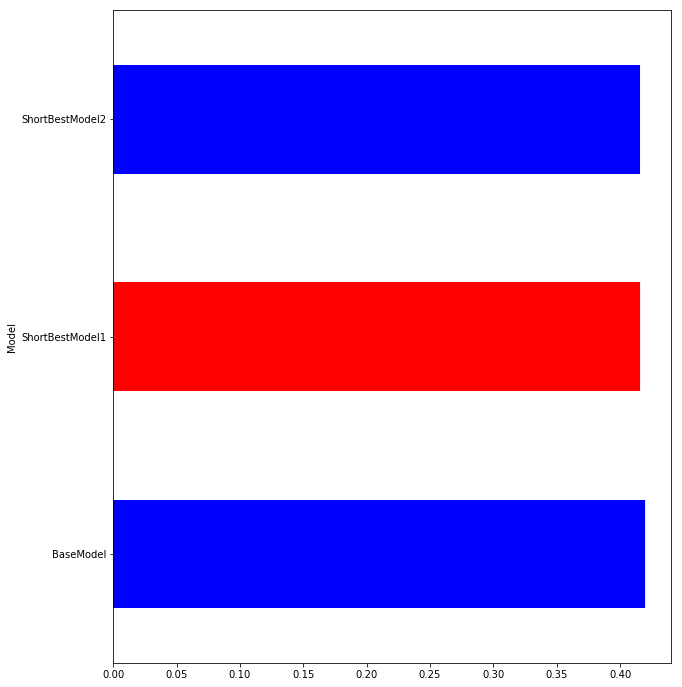

In [555]:
customcmap = tuple(models_test_gini_df['Group'].map(colors))
models_test_gini_df['Mean'].plot(kind='barh',  color=[customcmap], figsize=(10, 12))